## Homework 3  
Statistical techniques for Data Science and Robotics  
Made by Polina Turishcheva  
April 2022  
Innopolis University  

[Github Link](https://github.com/pollytur/STDS-R-2022/tree/main/hw3)

## Load data

In [101]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from matplotlib import animation

In [79]:
url = 'https://raw.githubusercontent.com/hflabs/city/master/city.csv'

In [80]:
df = pd.read_csv(url, sep=',',lineterminator='\n')
df_30_most_populated = df.iloc[df['population'].nlargest(30).index]
df_30_most_populated['city'] = df_30_most_populated.apply(lambda x: x['region'] if pd.isna(x['city']) else x['city'], axis=1)
df_30_most_populated = df_30_most_populated[['geo_lat', 'geo_lon', 'city']]
df_30_most_populated['coords'] = df_30_most_populated.apply(lambda x: (x['geo_lat'], x['geo_lon']), axis=1)
df_30_most_populated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,geo_lat,geo_lon,city,coords
509,55.754047,37.620405,Москва,"(55.7540471, 37.620405)"
786,59.939131,30.315900,Санкт-Петербург,"(59.9391313, 30.3159004)"
647,55.028191,82.921149,Новосибирск,"(55.028191, 82.9211489)"
832,56.838522,60.605491,Екатеринбург,"(56.8385216, 60.6054911)"
619,56.324063,44.005391,Нижний Новгород,"(56.3240627, 44.0053913)"
927,55.794358,49.111497,Казань,"(55.7943584, 49.1114975)"
782,53.195031,50.106952,Самара,"(53.1950306, 50.1069518)"
656,54.984857,73.367452,Омск,"(54.9848566, 73.3674517)"
1064,55.160262,61.400808,Челябинск,"(55.1602624, 61.4008078)"
757,47.222457,39.718803,Ростов-на-Дону,"(47.2224566, 39.718803)"


In [81]:
coords = df_30_most_populated['coords'].tolist()
names_dict = df_30_most_populated[['city', 'coords']].set_index('coords').to_dict()['city']

##Salemens implementation

Algorithm explanation: 
1. I try to run each simulated annealings with the same parameters $N$ times. I need it because the algoritm does not guarantee the best solution, as it is stochastic, hence, different initializations and different runs may lead for different results.
2. Randomly shuffle the input coordinates to have the initial path.
3. Based on this initial path, randomly swap 2 cities - this is a proposal path. 
4.  Calculate the distance in the initial path and the proposed one. If the distance in the new path is less, return the new path. Otherwise, calculate the $\alpha = exp((old\ distance - new\ distance)/current\ temperature )$. Generate random $p$ ~$U(0,1)$. If $\alpha >= p$ than accept the new path. New path is now the new "initial one".
5. Decrease the temperature every $temp\_update$ step by $cur\_temp = cur\_temp * annealing\_rate$
6. If the number of steps is above $max\_iter$ - stop this annealing cycle.
7. Repeat steps 3 - 6 while $cur\_temp < stop\_temp$
8. If new resulting path is shorter than the previous resulting path - update the best path and corresponding savins of distances and cities. The initial best path is the input one.
9. Repeat steps 2 - 7 $N$ times.


In [87]:
def path_distance(coords):
  '''
  Calculated distance for the whole path
  '''
  return sum([geodesic(coords[i - 1], coords[i]).km for i in range(len(coords))])


def swap_2_cities(coords):
  '''
  proposes a new path
  '''
  indxs = np.random.choice(len(coords), 2, replace=False)
  coords[indxs[0]], coords[indxs[1]] = coords[indxs[1]], coords[indxs[0]]
  return coords


def update(old_path, T):
  '''
  One step from the salesman algorithm
  '''
  new_path = old_path.copy()
  new_path = swap_2_cities(new_path)
  old_dist = path_distance(old_path)
  new_dist = path_distance(new_path)
  if new_dist < old_dist:
    return new_path
  alpha = np.exp((old_dist - new_dist) / T)
  p = np.random.uniform(0,1,1)[0]
  if alpha >= p:
    return new_path 
  return old_path

In [88]:
def annealing(coords, annealing_rate, start_temp=1_000_000, stop_temp=1, 
              temp_update=5, max_iter=10**7, N=3):
  '''
  * coords is the list of coordinates
  * temp_update is how often the temperature is updated (each temp_update's step)
  * max_iter is maximum number of iterations to stop, even if the temperature is not low enough yet.
  This is done to avoid too long waiting
  * N - is the number of times the salesmen algorithms is run 
  I need it because the algoritm does not guarantee the best solution, hence, 
  different initializations may lead for a different result
  '''
  best_path = coords.copy()
  best_dist_memory = []
  best_paths_memory = []
  for i in range(N):
    res_path = coords.copy()
    res_path = list(np.random.permutation(res_path))
    res_path = list(map(tuple, res_path))
    cur_temp = start_temp
    step = 0
    dist_memory = []
    paths_memory = []
    while cur_temp > stop_temp:
      res_path = update(res_path, cur_temp)
      step +=1
      if step % temp_update == 0:
        cur_temp *= annealing_rate
      paths_memory.append(res_path.copy())
      dist_memory.append(path_distance(res_path))
      if step > max_iter:
        break
    if path_distance(best_path) > path_distance(res_path):
      best_path = res_path.copy()
      best_dist_memory = dist_memory.copy()
      best_paths_memory = paths_memory.copy()

  return best_path, best_dist_memory, best_paths_memory

In [89]:
new_coords_09, dist_memory_09, paths_memory_09 = annealing(coords, annealing_rate=0.9)
new_coords_07, dist_memory_07, paths_memory_07 = annealing(coords, annealing_rate=0.7)
new_coords_05, dist_memory_05, paths_memory_05 = annealing(coords, annealing_rate=0.5)
new_coords_03, dist_memory_03, paths_memory_03 = annealing(coords, annealing_rate=0.3)
new_coords_01, dist_memory_01, paths_memory_01 = annealing(coords, annealing_rate=0.1)

Text(0.5, 1.0, 'Comparing different annealing rates convergence')

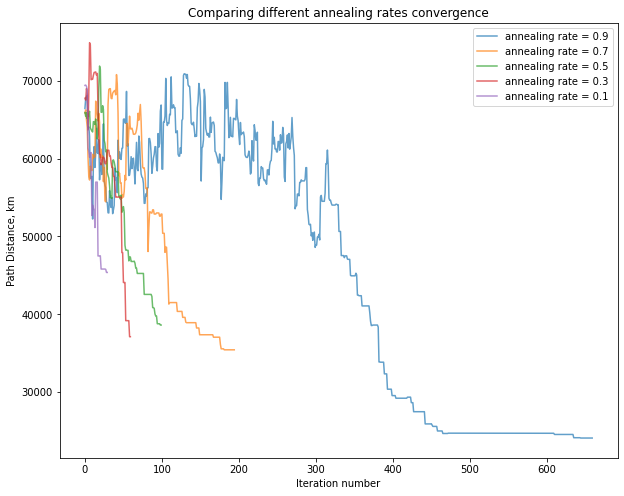

In [90]:
plt.figure(figsize=(10,8))
plt.plot(dist_memory_09, label='annealing rate = 0.9', alpha=0.7)
plt.plot(dist_memory_07, label='annealing rate = 0.7', alpha=0.7)
plt.plot(dist_memory_05, label='annealing rate = 0.5', alpha=0.7)
plt.plot(dist_memory_03, label='annealing rate = 0.3', alpha=0.7)
plt.plot(dist_memory_01, label='annealing rate = 0.1', alpha=0.7)
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Path Distance, km')
plt.title('Comparing different annealing rates convergence')

Text(0.5, 1.0, 'Comparing different annealing rates convergence')

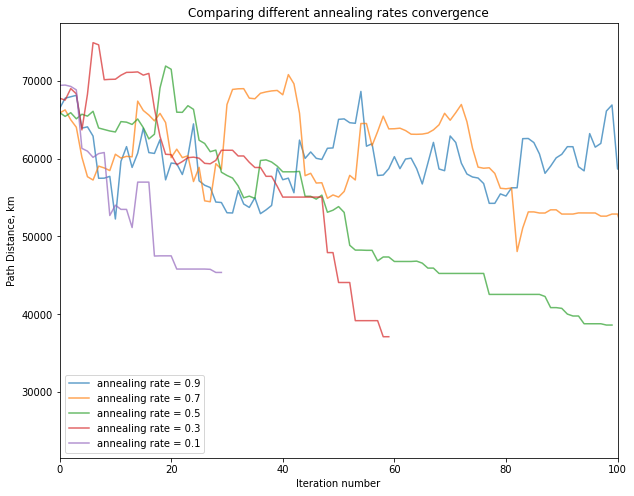

In [91]:
plt.figure(figsize=(10,8))
plt.plot(dist_memory_09, label='annealing rate = 0.9', alpha=0.7)
plt.plot(dist_memory_07, label='annealing rate = 0.7', alpha=0.7)
plt.plot(dist_memory_05, label='annealing rate = 0.5', alpha=0.7)
plt.plot(dist_memory_03, label='annealing rate = 0.3', alpha=0.7)
plt.plot(dist_memory_01, label='annealing rate = 0.1', alpha=0.7)
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Path Distance, km')
plt.xlim(0, 100)
plt.title('Comparing different annealing rates convergence')

In [92]:
print(f'Final distance for annealing_rate=0.9 is {path_distance(new_coords_09)}')
print(f'Final distance for annealing_rate=0.7 is {path_distance(new_coords_07)}')
print(f'Final distance for annealing_rate=0.5 is {path_distance(new_coords_05)}')
print(f'Final distance for annealing_rate=0.3 is {path_distance(new_coords_03)}')
print(f'Final distance for annealing_rate=0.1 is {path_distance(new_coords_01)}')

Final distance for annealing_rate=0.9 is 24088.446782634393
Final distance for annealing_rate=0.7 is 35428.595036195286
Final distance for annealing_rate=0.5 is 38612.17356230852
Final distance for annealing_rate=0.3 is 37112.942725614324
Final distance for annealing_rate=0.1 is 45375.658064883835


In [96]:
print(f'Final path for annealing_rate=0.9 is {"->".join([names_dict[i] for i in new_coords_09])}')
print(f'Final path for annealing_rate=0.7 is {"->".join([names_dict[i] for i in new_coords_07])}')
print(f'Final path for annealing_rate=0.5 is {"->".join([names_dict[i] for i in new_coords_05])}')
print(f'Final path for annealing_rate=0.3 is {"->".join([names_dict[i] for i in new_coords_03])}')
print(f'Final path for annealing_rate=0.1 is {"->".join([names_dict[i] for i in new_coords_01])}')

Final path for annealing_rate=0.9 is Москва->Воронеж->Саратов->Санкт-Петербург->Ярославль->Нижний Новгород->Ульяновск->Казань->Тольятти->Волгоград->Махачкала->Оренбург->Челябинск->Екатеринбург->Ижевск->Ростов-на-Дону->Краснодар->Самара->Тюмень->Кемерово->Красноярск->Владивосток->Хабаровск->Иркутск->Новокузнецк->Барнаул->Новосибирск->Омск->Пермь->Уфа
Final path for annealing_rate=0.7 is Хабаровск->Кемерово->Саратов->Воронеж->Тольятти->Москва->Уфа->Челябинск->Пермь->Самара->Оренбург->Новосибирск->Барнаул->Екатеринбург->Ульяновск->Казань->Нижний Новгород->Ярославль->Санкт-Петербург->Ижевск->Волгоград->Краснодар->Ростов-на-Дону->Махачкала->Омск->Тюмень->Владивосток->Иркутск->Красноярск->Новокузнецк
Final path for annealing_rate=0.5 is Хабаровск->Омск->Барнаул->Красноярск->Новосибирск->Новокузнецк->Владивосток->Иркутск->Челябинск->Самара->Тольятти->Волгоград->Махачкала->Нижний Новгород->Саратов->Москва->Санкт-Петербург->Ярославль->Ижевск->Пермь->Кемерово->Екатеринбург->Тюмень->Оренбург->Каз

## My findings

* The bigger is the annealing rate, the slower the temperature decreases, hence, the algoruthm makes more trials and the resulting path is shorter. 
* The smaller the annealing rate, the faster is the initial convergence because  the temperature decreases faster, which means that the denominator in the exponent decreases faster. So the alpha value is bigger and algorythm is more likely to make changes on each step, therefore, it explores faster. However, it seems that the algorithm stops too early before the optimum (bigger initial temperature or bigger distance between temperature updates may help).


## Path Updates Visualization

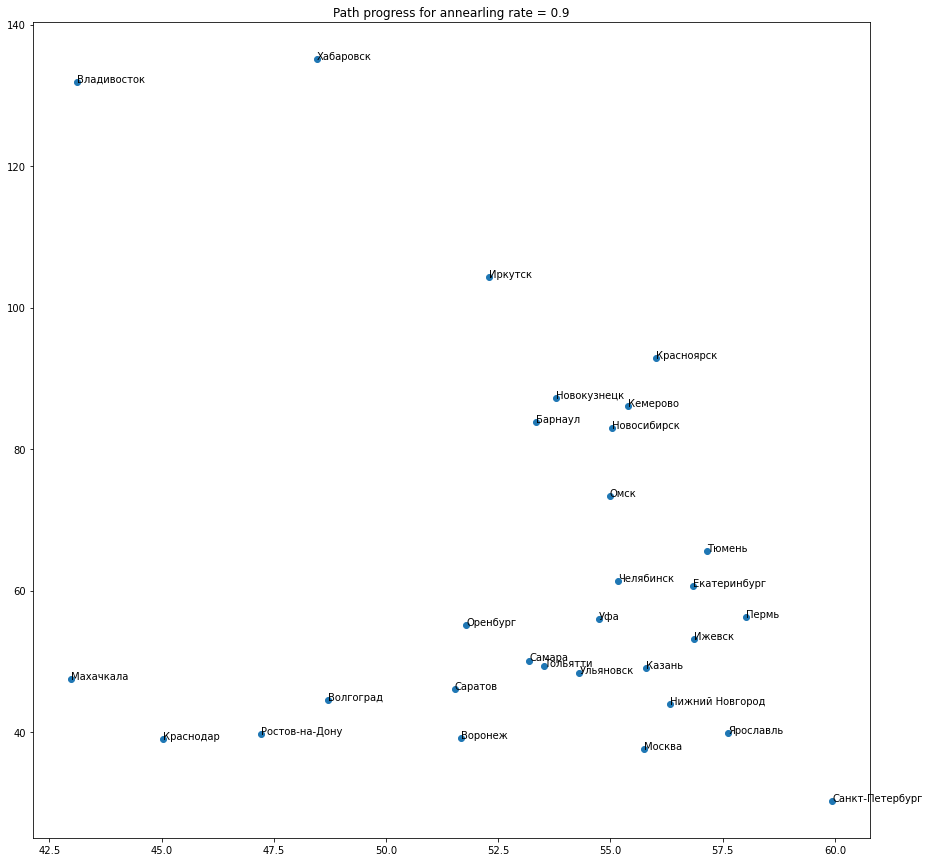

In [134]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.scatter([i[0] for i in coords], [i[1] for i in coords])
plt.title('Path progress for annearling rate = 0.9')
for i in coords:
    ax.annotate(names_dict[i], (i[0], i[1]), fontsize='medium')
connections = ax.plot([], [], lw=2)[0]
cur_dist = ax.text(50, 130, '', bbox=dict(facecolor='blue', alpha=0.3))

In [135]:
def init():
  connections.set_data([], [])
  cur_dist.set_text('')
  return connections,

def step_animation(step):
  x = [i[0] for i in paths_memory_09[step]]
  y = [i[1] for i in paths_memory_09[step]]
  connections.set_data(x, y)
  cur_dist.set_text(f'Current distance = {np.round(path_distance(paths_memory_09[step]))} km')
  return connections



city_animation = animation.FuncAnimation(fig, step_animation, init_func=init, 
                                         frames=len(paths_memory_09), 
                                         interval=10, repeat=False, blit=False)

city_animation.save('city_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])